<a href="https://colab.research.google.com/github/vicmcl/ml-laptime/blob/main/ml_laptime/notebook/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
from pathlib import Path
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
# Mount Drive
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "laptime-simulation"

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
data_path = glob.glob(str(ML_PATH / "races_*.pkl"))

In [4]:
pip install -q fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.3/148.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
data_path

['/content/drive/MyDrive/Projects/laptime-simulation/races_2021.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2020.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2019.pkl']

In [117]:
data = {}
with open(data_path[0], "rb") as f:
    data[2021] = pickle.load(f)

with open(data_path[1], "rb") as f:
    data[2020] = pickle.load(f)

with open(data_path[2], "rb") as f:
    data[2019] = pickle.load(f)

In [125]:
gp_list = data[2021].keys() & data[2020].keys() & data[2019].keys()
gp_list

{'Abu Dhabi Grand Prix',
 'Austrian Grand Prix',
 'Bahrain Grand Prix',
 'Belgian Grand Prix',
 'Hungarian Grand Prix',
 'Russian Grand Prix',
 'Spanish Grand Prix'}

In [6]:
columns_laps = [
    'Time', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
    'Compound', 'TyreLife', 'LapTime'
]

columns_telemetry = ['SessionTime', 'Throttle', 'Brake', 'DRS']

columns_weather = ['Time', 'TrackTemp', 'WindSpeed']

compound_map = {
    'SOFT': 1.0,
    'MEDIUM': 2.0,
    'HARD': 3.0
}

In [7]:
def process_lap_data(gp, year):
    laps_data = data[year][gp]['laps'][columns_laps].copy()
    laps_data['Season'] = year
    laps_data = laps_data.reset_index().drop('index', axis=1)
    laps_data['Compound'] = laps_data['Compound'].map(lambda x: compound_map.get(x, 0.0))
    return laps_data

In [8]:
def map_drs(drs):
    if drs >= 10:
        return True
    else:
        return False

def process_telemetry_data(gp, year, laps):
    telemetry_data = data[year][gp]['telemetry'][columns_telemetry].copy()
    telemetry_with_laps = pd.merge_asof(
        telemetry_data,
        laps[['Time', 'LapNumber']],
        left_on='SessionTime',
        right_on='Time',
        direction='forward'
    ).drop('Time', axis=1)
    telemetry_with_laps.loc[:, 'DRS'] = telemetry_with_laps['DRS'].map(map_drs)
    telemetry_avg = telemetry_with_laps.groupby('LapNumber').mean()
    return telemetry_avg

In [9]:
def process_weather_data(gp, year):
    weather_data = data[year][gp]['weather'][columns_weather].copy()
    return weather_data

In [10]:
def merge_data(laps, weather, telemetry):
    merged_data = pd.merge_asof(laps, weather, on='Time', direction='nearest').set_index('LapNumber').drop('Time', axis=1)
    merged_data = pd.concat([merged_data, telemetry], axis=1).reset_index()
    merged_data = merged_data.drop('SessionTime', axis=1)
    merged_data.loc[:, 'LapTime'] = merged_data['LapTime'].map(lambda x: x.total_seconds())
    return merged_data

In [11]:
def preprocess_data(gp, year):
    laps = process_lap_data(gp, year)
    weather = process_weather_data(gp, year)
    telemetry = process_telemetry_data(gp, year, laps)
    merged_data = merge_data(laps, weather, telemetry)
    return merged_data

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

si = SimpleImputer()

In [126]:
gp = 'Austrian Grand Prix'
df = pd.DataFrame()

for year in sorted(list(data.keys())):
    prepro_data = preprocess_data(gp, year)
    for col in prepro_data.columns:
        prepro_data[col] = si.fit_transform(prepro_data[[col]])
    df = pd.concat([df, prepro_data])

df = df.reset_index(drop=True)
df = df.dropna(subset='LapTime')

In [127]:
df.info()

<class 'fastf1.core.Laps'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LapNumber  152 non-null    float64
 1   Stint      152 non-null    float64
 2   SpeedI1    152 non-null    float64
 3   SpeedI2    152 non-null    float64
 4   SpeedFL    152 non-null    float64
 5   SpeedST    152 non-null    float64
 6   Compound   152 non-null    float64
 7   TyreLife   152 non-null    float64
 8   LapTime    152 non-null    float64
 9   Season     152 non-null    float64
 10  TrackTemp  152 non-null    float64
 11  WindSpeed  152 non-null    float64
 12  Throttle   152 non-null    float64
 13  Brake      152 non-null    float64
 14  DRS        152 non-null    float64
dtypes: float64(15)
memory usage: 17.9 KB


In [33]:
df

,LapNumber,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Compound,TyreLife,LapTime,Season,TrackTemp,WindSpeed,Throttle,Brake,DRS
0,1.0,1.0,278.0,301.0,216.0,298.0,2.0,4.0,102.867981,2019.0,30.5,1.5,59.717146,0.212766,0.0
1,2.0,1.0,276.0,284.0,214.0,295.0,2.0,5.0,103.281000,2019.0,30.6,1.5,61.994819,0.189119,0.0
2,3.0,1.0,272.0,285.0,214.0,293.0,2.0,6.0,103.245000,2019.0,30.3,1.5,62.760618,0.177606,0.0
3,4.0,1.0,271.0,283.0,215.0,293.0,2.0,7.0,103.308000,2019.0,30.3,0.9,62.631714,0.182864,0.0
4,5.0,1.0,270.0,282.0,215.0,291.0,2.0,8.0,103.506000,2019.0,30.3,1.1,61.287918,0.178663,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,67.0,5.0,309.0,253.0,303.0,304.0,3.0,27.0,73.958000,2021.0,46.3,0.4,61.269767,0.201550,0.0
177,68.0,5.0,308.0,251.0,296.0,301.0,3.0,28.0,74.425000,2021.0,46.1,0.3,60.810478,0.181818,0.0
178,69.0,5.0,303.0,251.0,303.0,291.0,3.0,29.0,74.389000,2021.0,45.5,0.4,61.536321,0.188563,0.0
179,70.0,5.0,307.0,250.0,302.0,297.0,3.0,30.0,74.407000,2021.0,44.6,0.5,60.864407,0.186441,0.0


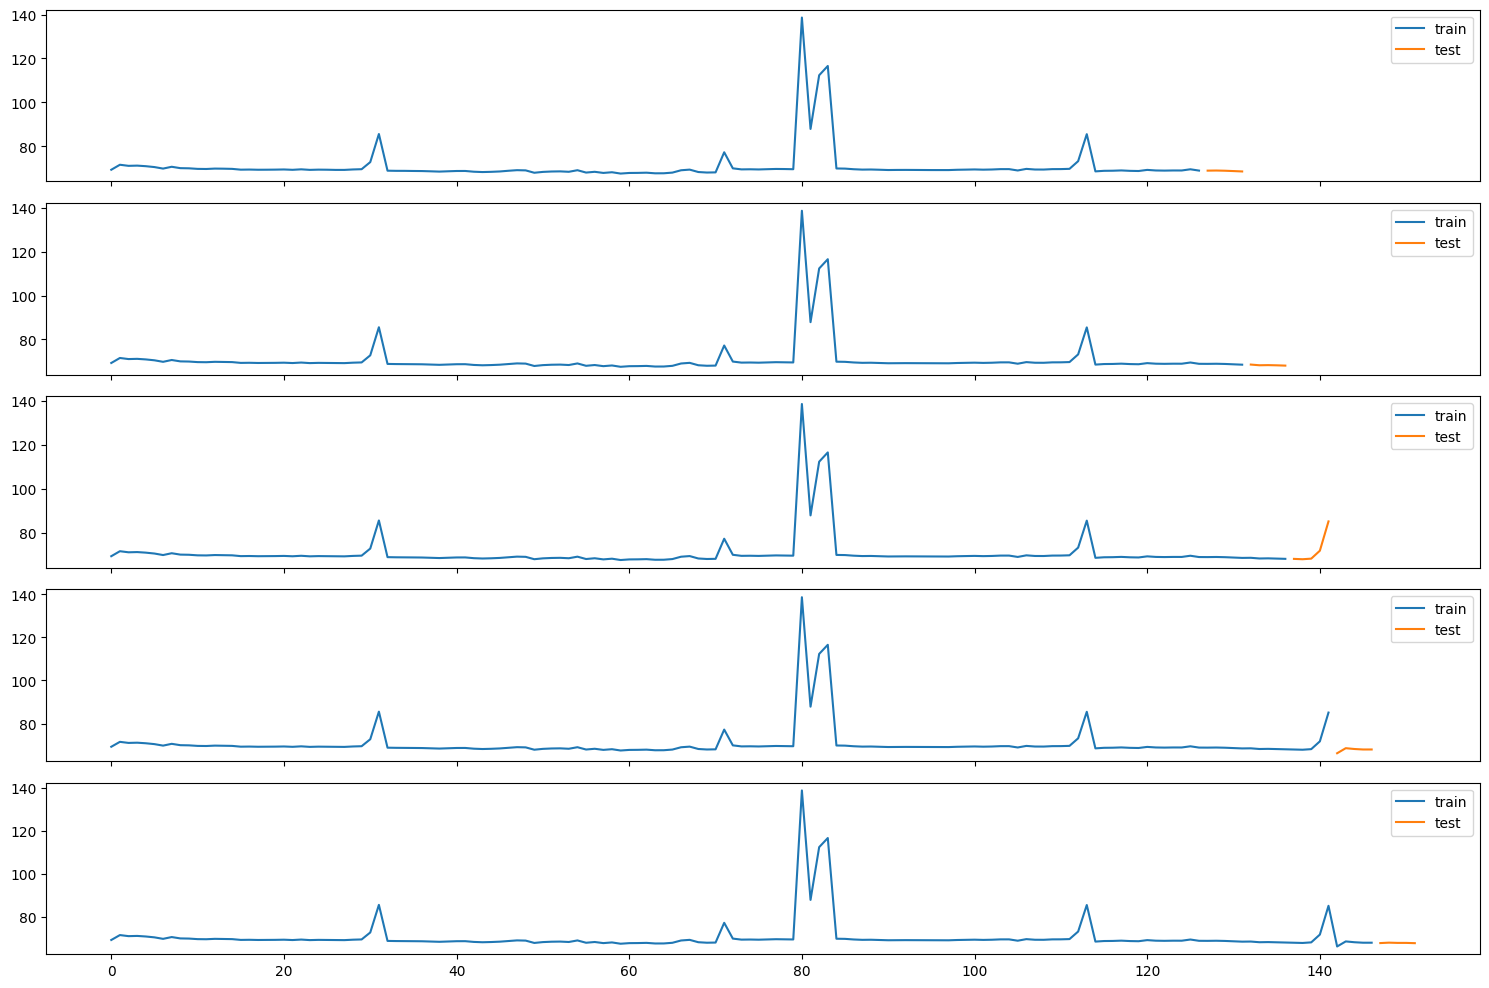

In [133]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=5)

fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
fold = 0
for train_idx, test_idx in tss.split(df):
    train = df.loc[train_idx]
    test = df.loc[test_idx]
    train['LapTime'].plot(ax=axs[fold], label='train')
    test['LapTime'].plot(ax=axs[fold], label='test')
    axs[fold].legend()
    fold += 1
plt.tight_layout()
plt.show()

In [91]:
def select_speed_trap(data):
    corr = data[['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']].corr()
    speed_trap = corr['LapTime'].iloc[1:].abs().idxmax()
    return speed_trap

def filter_speed_trap(data, speed_trap):
    data = data.drop([speed for speed in ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST'] if speed != speed_trap], axis=1)
    data = data.rename(columns={speed_trap: 'SpeedTrap'})
    return data

In [134]:
for train_idx, test_idx in tss.split(df):
    break

speed_trap = select_speed_trap(df.loc[train_idx])

df = filter_speed_trap(df, speed_trap)

In [136]:
df['LagLapTime'] = df['LapTime'].shift(1)
df['LagSpeedTrap'] = df['SpeedTrap'].shift(1)
df['RollingMeanLapTime'] = df['LapTime'].rolling(window=5).mean()
df['RollingMeanSpeedTrap'] = df['SpeedTrap'].rolling(window=5).mean()

In [143]:
FEATURES = list(df.columns)
FEATURES.remove('LapTime')
TARGET = 'LapTime'

In [148]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

preds = []
scores = []

for train_idx, test_idx in tss.split(df):
    X_train, y_train = df.loc[train_idx, FEATURES], df.loc[train_idx, TARGET]
    X_test, y_test = df.loc[test_idx, FEATURES], df.loc[test_idx, TARGET]


    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        early_stopping_rounds=50,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = mean_squared_error(y_test, y_pred, squared=False)
    scores.append(score)

[0]	validation_0-rmse:8.63867	validation_1-rmse:2.13683
[100]	validation_0-rmse:4.34196	validation_1-rmse:0.97251
[200]	validation_0-rmse:2.47948	validation_1-rmse:0.53978
[300]	validation_0-rmse:1.47169	validation_1-rmse:0.42015
[400]	validation_0-rmse:0.88797	validation_1-rmse:0.36709
[500]	validation_0-rmse:0.54214	validation_1-rmse:0.34686
[600]	validation_0-rmse:0.33453	validation_1-rmse:0.34379
[700]	validation_0-rmse:0.21055	validation_1-rmse:0.33694
[786]	validation_0-rmse:0.14530	validation_1-rmse:0.33588
[0]	validation_0-rmse:8.48334	validation_1-rmse:2.53533
[100]	validation_0-rmse:4.26418	validation_1-rmse:1.00441
[200]	validation_0-rmse:2.43482	validation_1-rmse:0.44856
[300]	validation_0-rmse:1.44522	validation_1-rmse:0.25357
[400]	validation_0-rmse:0.87222	validation_1-rmse:0.18393
[500]	validation_0-rmse:0.53276	validation_1-rmse:0.15323
[600]	validation_0-rmse:0.32845	validation_1-rmse:0.13724
[700]	validation_0-rmse:0.20697	validation_1-rmse:0.12451
[800]	validation_0